# The SU interface
## Introduction
As discussed in the main introduction a numpy array has been defined which imitates the binary structure of a [Seismic Unix](https://en.wikipedia.org/wiki/Seismic_Unix) (SU) file.  

Why an SU file? A number of reasons

1. Seismic data is a time series (trace) along with some other information (headers).  Headers will contain information like spatial locations (i.e. source and geophone locations), the number of samples and sample rate.  If the order of traces needs to be changed for some reason, the order of the headers need to be changed as well.  A separate data structure can be used to track the headers, but it is much simpler to combine the header and trace into a single entity.  In numpy this is a structured array.  The only difference between an abitrary structured array and an SU structured array is the headers are pre-defined by a standard - specifically the SEG SEGY trace header defition.  
2. The SU file is essentially a subset of a [SEGY](https://en.wikipedia.org/wiki/SEG_Y) file with some minor changes. One of those changes, the use of IEEE floats instead of [IBM floats](https://en.wikipedia.org/wiki/IBM_Floating_Point_Architecture#Special_uses), is why SU files play well with python.  A SEGY-python interface requires an IBM/IEEE conversion, not to mention a EBCDIC decoder. Converstions exist, and are available in PySeis, but SU is just so much simpler...
3. Simpler is easier to teach.  Understanding the structure of an SU file leads to an understanding of the associated numpy structured array. 
4. SU has been around since the 70s.  It is maintained by [CWP](http://www.cwp.mines.edu/) and is compatible with a range of software packages, for example [Madagascar](http://www.ahay.org/wiki/Main_Page). The existance of other software packages that support the file type means that PySeis can lean on these other packages for features which are not yet available, as well as cross-check results against mature software.

So why not just use SU directly?

1. Because I have to teach to students using windows computers to which we dont have administrative rights.
2. Because SU is mature code, written in C, and is heavily optimised. Writing new modules for seismic unix natively is not really possible without a strong coding background. A PySeis module can be written in 3 lines (excluding the type definition). A PySeis module which can be inserted into a seismic unix flow can be written in 5 lines. It can be taught to students in a few minutes.
3. SU exists as a standalone software package, developed by a dedicated, but small group.  Python is [not](https://wiki.python.org/moin/OrganizationsUsingPython). You get much, much more out of the box once you move to python.

What are some of the downsides of using Python?

1. Python has performance issues.  It can be optimised, but that generally breaks the readability
2. It's a moving target. Programs often depend upon the correct dependencies being pre-installed
3. The [GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock). Yuck.






## The SU file

All data on computers is stored as ones and zeros. Each one or zero is referred to as a bit. A group of 8 bits (an 8 bit "word") is referred to as a byte.

The actual order of the ones and zeros, the 'encoding', depends on it's [type](https://en.wikipedia.org/wiki/Data_type). Whole numbers (integers) such as 1, 2, 3 and 4 are easy - they are stored as the direct binary equivalent. Generally, 4 bytes are allocated to store each integer  - that is, 32 bits.  Thus, there are $2^{32}$ possible combinations available.  If you dont care about negative numbers, these can all be positive (unsigned).  But generally we want both positive and negative numbers (signed).



In [1]:
print "unsigned (positive numbers only) 2^32 = ", 2**32
print 'signed (positive and negative numnbers) (2^32/2) -1 = ', 2**32/2-1 #have to account for zero
print "the binary representation of 0 is ", bin(0)
print "the binary representation of (2^32/2)-1 (signed) is ", bin(2**32/2-1)

unsigned (positive numbers only) 2^32 =  4294967296
signed (positive and negative numnbers) (2^32/2) -1 =  2147483647
the binary representation of 0 is  0b0
the binary representation of (2^32/2)-1 (signed) is  0b1111111111111111111111111111111


Numbers with decimal points are refered to as floating point numbers (floats).  Obviously if you're working with ones and zeros, you cant really store a decimal point.  So special encodings are used, for example [IEEE floats](https://en.wikipedia.org/wiki/IEEE_floating_point). 

These numbers do not *have* to be 4 bytes.  If you know you dont need $2^{32}$ integers, you can use 2 bytes ($2^{16}$), often called a short integer. If 32 bits isnt enough, you can use 64 ($2^{64}$), called a long int.  A more complete list of fundamental data types available to numpy can be seen [here](http://docs.scipy.org/doc/numpy/user/basics.types.html).

Why is this important? Lets have a quick look at the [SU header definition](http://www.geo.uib.no/eworkshop/index.php?n=Main.SeismicUnix#toc6). There are 71 entries, a mixture of 2 byte and 4 byte integers.  Most entries are not usually used, but there are some "highly recommended" entries:

```
Byte #    2/4-byte   SU Keyword    Description    
001 - 004    4     *  tracl        Trace sequence number within line.                                   
009 - 012    4     *  fldr         Original field record number.                                        
013 - 016    4     *  tracf        Trace sequence number within original field record.                  
029 - 030    2     *  trid         Trace identification code:                                           
115 - 116    2     *  ns            Number of samples in this trace.                                     
117 - 118    2     *  dt            Sample interval of this trace in microseconds.   
```
to this list I will add 4 more entries:
```
073 - 076    4       sx            X source coordinate.                                                 
077 - 080    4       sy            Y source coordinate.                                                 
081 - 084    4       gx            X receiver group coordinate.                                         
085 - 088    4       gy            Y receiver group coordinate. 
```

So the first 4 bytes contain an integer called "tracl", etc. Interestingly, "ns" is a 2 byte integer, a short, which is actually a significant limitation.  2 bytes = 16 bits = $2^{16}$ samples.


In [2]:
print "thus a single trace can only contain 2^16 (%d) samples" %2**16

thus a single trace can only contain 2^16 (65536) samples


If we assume a 1ms sample rate ("dt" = 1000), then a single trace can only contain 65 seconds of data.  This seems like a lot, until you consider a surface source like mini-SOSIE can easily record a single event for over a minute. 

Another limitation is the coordinates themselves.  As 4 byte integers, they cannot store fractional information.  Assuming an easting/northing coordinate system (highly recommended) this limits the resolution to 1 metre. You can get around this, but we'll leave that for later.

So the SU files has the following format:

Item | Size (bytes) |    cumulative sum(bytes)
:------------:|:---------------:|:---------------:
header|$240$|$240$
trace| $ns*4$|$240+4ns$
header|$240$|$240+(240+4ns)$
trace| $ns*4$|$2(240+4ns)$
header|$240$|$240+2(240+4ns)$
trace|$ns*4$|$3(240+4ns)$
header|$240$|$240+3(240+4ns)$
trace| $ns*4$|$4(240+4ns)$
....|....|....
EOF|total file size|$nt*(240+4ns)$

Where "ns" is the number of samples and "nt" is the number of traces.

Populating the interactive namespace from numpy and matplotlib


/home/sfletcher/.virtualenv/python/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


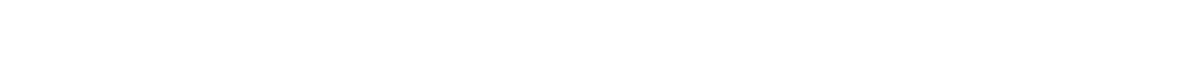

In [3]:
import su
import numpy as np
%pylab nbagg
sutype = su.su_header_dtype
headers = [sutype[item].itemsize for item in sutype.fields]
headers_cumsum = np.cumsum(headers)
n = 0
pylab.figure(figsize=(15,1))
for i in range(4):
    plot(n+headers_cumsum, np.zeros_like(headers_cumsum), 'r.', label='header')
    plot(n+np.arange(500*4)+240, np.zeros(500*4),'b.', label='trace')
    n += 240+(500*4)


    

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


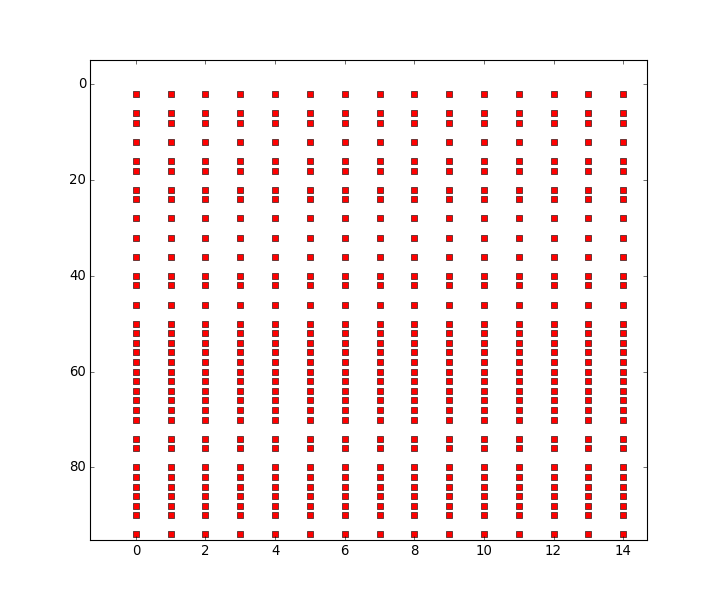

In [10]:
import su
import numpy as np
%pylab nbagg
sutype = su.su_header_dtype
headers = [sutype[item].itemsize for item in sutype.fields]
headers_cumsum = np.cumsum(headers)
n = 0
pylab.figure(figsize=(5,5))
for i in range(100):
    plot(np.ones_like(headers_cumsum)*i,headers_cumsum, 'rs', label='header')
    plot(np.ones(500)*i,n+np.arange(0,500*4,4)+240,'bs', label='trace')
pylab.ylim([1000,0])
pylab.show()
